# Train a Model for Detecting Surface Water

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/train_water_detection.ipynb)

## Install package
To use the `geoai-py` package, ensure it is installed in your environment. Uncomment the command below if needed.

In [1]:
%pip install geoai-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.8/278.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.4/629.4 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import libraries

In [2]:
import geoai

## Download sample data

In [3]:
train_raster_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip/naip_water_train.tif"
train_masks_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip/naip_water_masks.tif"
test_raster_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip/naip_water_test.tif"

In [4]:
train_raster_path = geoai.download_file(train_raster_url)
train_masks_path = geoai.download_file(train_masks_url)
test_raster_path = geoai.download_file(test_raster_url)

In [5]:
geoai.print_raster_info(train_raster_path, show_preview=False)

===== RASTER INFORMATION: naip_water_train.tif =====
Driver: GTiff
Dimensions: 5390 x 7580 pixels
Number of bands: 4
Data type: uint8
Coordinate Reference System: EPSG:26914
Georeferenced Bounds: BoundingBox(left=485430.0, bottom=5204860.0, right=490820.0, top=5212440.0)
Pixel Resolution: 1.0, 1.0
NoData Value: None

----- Band Statistics -----
Band 1:
  Min: 36.00
  Max: 238.00
  Mean: 127.01
  Std Dev: 34.38
Band 2:
  Min: 46.00
  Max: 233.00
  Mean: 121.56
  Std Dev: 22.03
Band 3:
  Min: 57.00
  Max: 237.00
  Mean: 105.59
  Std Dev: 18.37
Band 4:
  Min: 19.00
  Max: 238.00
  Mean: 135.77
  Std Dev: 36.26


## Visualize sample data

In [7]:
geoai.view_raster(train_masks_url, nodata=0, basemap=train_raster_url)

In [8]:
geoai.view_raster(test_raster_url)

## Create training data

In [9]:
out_folder = "output"

In [10]:
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_masks_path,
    tile_size=512,
    stride=128,
    buffer_radius=0,
)

Detected in_class_data as raster: naip_water_masks.tif
Raster CRS: EPSG:26914
Raster dimensions: 5420 x 7602

Raster info for naip_water_train.tif:
  CRS: EPSG:26914
  Dimensions: 5390 x 7580
  Resolution: (1.0, 1.0)
  Bands: 4
  Bounds: BoundingBox(left=485430.0, bottom=5204860.0, right=490820.0, top=5212440.0)
Found 1 unique classes in raster: [1]


Generated: 2280, With features: 2170: 100%|██████████| 2280/2280 [03:09<00:00, 12.03it/s]


------- Export Summary -------
Total tiles exported: 2280
Tiles with features: 2170 (95.2%)
Average feature pixels per tile: 101525.1
Output saved to: output

------- Georeference Verification -------


## Train object detection model

In [11]:

import torch
import os

# 2. Check for GPU and set the device
# This is the standard code to verify the "cuda env"
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'✅ GPU is available and ready!')
    print(f'Device name: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('⚠️ WARNING: GPU not available, using CPU.')
    print('Please go to "Runtime" -> "Change runtime type" and select a GPU.')

# 3. (Optional) Set an environment variable
# Some libraries look for this to know which GPU to use
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print('---')
print(f'Setup complete. The geoai library will now automatically use: {device}')

✅ GPU is available and ready!
Device name: Tesla T4
---
Setup complete. The geoai library will now automatically use: cuda


In [12]:
geoai.train_MaskRCNN_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    num_channels=4,
    pretrained=True,
    batch_size=4,
    num_epochs=10,
    learning_rate=0.005,
    val_split=0.2,
)

Using device: cuda
Found 2280 image files and 2280 label files
Training on 1824 images, validating on 456 images
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:02<00:00, 84.0MB/s]


Epoch: 1, Batch: 1/456, Loss: 5.4483, Time: 6.40s
Epoch: 1, Batch: 11/456, Loss: 2.3373, Time: 12.75s
Epoch: 1, Batch: 21/456, Loss: 0.7712, Time: 13.06s
Epoch: 1, Batch: 31/456, Loss: 1.5054, Time: 13.21s
Epoch: 1, Batch: 41/456, Loss: 1.2565, Time: 13.51s
Epoch: 1, Batch: 51/456, Loss: 0.9499, Time: 13.67s
Epoch: 1, Batch: 61/456, Loss: 1.0673, Time: 13.76s
Epoch: 1, Batch: 71/456, Loss: 0.7772, Time: 13.87s
Epoch: 1, Batch: 81/456, Loss: 0.6060, Time: 14.00s
Epoch: 1, Batch: 91/456, Loss: 0.8118, Time: 14.03s
Epoch: 1, Batch: 101/456, Loss: 0.6875, Time: 14.19s
Epoch: 1, Batch: 111/456, Loss: 0.7666, Time: 14.17s
Epoch: 1, Batch: 121/456, Loss: 0.7356, Time: 14.32s
Epoch: 1, Batch: 131/456, Loss: 0.7911, Time: 14.54s
Epoch: 1, Batch: 141/456, Loss: 0.2872, Time: 14.24s
Epoch: 1, Batch: 151/456, Loss: 1.0971, Time: 14.47s
Epoch: 1, Batch: 161/456, Loss: 0.7914, Time: 14.66s
Epoch: 1, Batch: 171/456, Loss: 0.6762, Time: 14.78s
Epoch: 1, Batch: 181/456, Loss: 0.8660, Time: 14.80s
Epoch

KeyboardInterrupt: 

## Run inference

In [67]:
masks_path = "naip_water_prediction.tif"
model_path = f"{out_folder}/models/best_model.pth"

In [68]:
geoai.object_detection(
    test_raster_path,
    masks_path,
    model_path,
    window_size=512,
    overlap=128,
    confidence_threshold=0.3,
    batch_size=4,
    num_channels=4,
)

Processing 280 windows with size 512x512 and overlap 128...


315it [00:31,  9.93it/s]


Inference completed in 32.13 seconds
Saved prediction to naip_water_prediction.tif


## Vectorize masks

In [69]:
output_path = "naip_water_prediction.geojson"
gdf = geoai.raster_to_vector(
    masks_path, output_path, min_area=1000, simplify_tolerance=1
)

Vectorized data saved to naip_water_prediction.geojson


In [70]:
gdf = geoai.add_geometric_properties(gdf)

In [71]:
len(gdf)

79

In [72]:
# Identify duplicate columns
duplicate_columns = gdf_filtered.columns[gdf_filtered.columns.duplicated()]
if not duplicate_columns.empty:
    print(f"Warning: Duplicate columns found: {list(duplicate_columns)}. Dropping duplicates.")
    # Drop duplicate columns
    gdf_filtered = gdf_filtered.loc[:, ~gdf_filtered.columns.duplicated()]

geoai.view_vector_interactive(gdf_filtered, tiles=test_raster_url)

<Axes: >

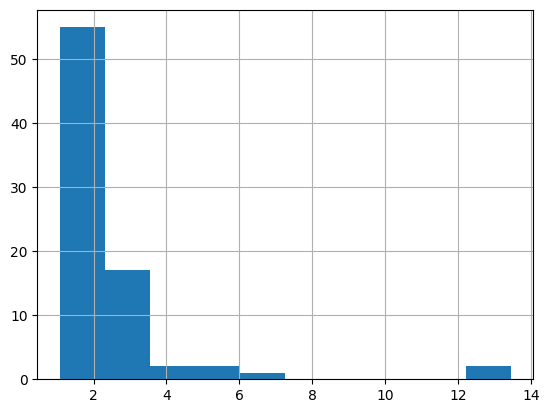

In [62]:
gdf["elongation"].hist()

In [63]:
gdf_filtered = gdf[gdf["elongation"] < 10]

# Identify and drop duplicate columns after filtering
duplicate_columns = gdf_filtered.columns[gdf_filtered.columns.duplicated()]
if not duplicate_columns.empty:
    print(f"Warning: Duplicate columns found: {list(duplicate_columns)}. Dropping duplicates.")
    gdf_filtered = gdf_filtered.loc[:, ~gdf_filtered.columns.duplicated()]

In [64]:
len(gdf_filtered)

77

## Visualize results

In [65]:
from google.colab import output
output.disable_custom_widget_manager()

In [66]:
geoai.view_vector_interactive(gdf_filtered, tiles=test_raster_url)

In [44]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [45]:
from google.colab import output
output.disable_custom_widget_manager()

In [46]:
display(gdf_filtered.head())
display(gdf_filtered.info())

,geometry,class,area_m2,length_m,perimeter_m,area_bbox_m2,area_convex_m2,area_filled_m2,major_length_m,minor_length_m,eccentricity,orientation,elongation,extent,solidity,complexity
0,"POLYGON ((492940 5212429, 492937 5212426, 4929...",1,10792.0,631.808745,631.808745,14950.0,11057.0,10792.0,299.000000,50.000000,0.985919,0.000000,5.980000,0.721873,0.976033,1.715654
1,"POLYGON ((491652 5212081, 491651 5212076, 4916...",1,2242.5,196.527353,196.527353,3942.0,2428.5,2242.5,71.479742,43.059225,0.798196,38.233825,1.660033,0.568874,0.923410,1.170717
2,"POLYGON ((494934 5212401, 494919 5212398, 4949...",1,97747.0,1275.620254,1275.620254,129232.0,100147.5,98141.0,391.499702,328.689476,0.543259,92.489553,1.191093,0.756368,0.976030,1.150972
3,"POLYGON ((495398 5211999, 495392 5211990, 4953...",1,1188.0,255.263573,255.263573,4386.0,2041.5,1188.0,106.252529,22.135944,0.978058,71.565051,4.800000,0.270862,0.581925,2.089179
4,"POLYGON ((492384 5212429, 492377 5212426, 4923...",1,246701.0,2194.678826,2194.678826,387710.0,279053.0,246701.0,687.990206,546.866617,0.606772,6.275851,1.258059,0.636303,0.884065,1.246466


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 77 entries, 0 to 78
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geometry        77 non-null     geometry
 1   class           77 non-null     int64   
 2   area_m2         77 non-null     float64 
 3   length_m        77 non-null     float64 
 4   perimeter_m     77 non-null     float64 
 5   area_bbox_m2    77 non-null     float64 
 6   area_convex_m2  77 non-null     float64 
 7   area_filled_m2  77 non-null     float64 
 8   major_length_m  77 non-null     float64 
 9   minor_length_m  77 non-null     float64 
 10  eccentricity    77 non-null     float64 
 11  orientation     77 non-null     float64 
 12  elongation      77 non-null     float64 
 13  extent          77 non-null     float64 
 14  solidity        77 non-null     float64 
 15  complexity      77 non-null     float64 
dtypes: float64(14), geometry(1), int64(1)
memory usage: 10.2 KB


None

In [47]:
geoai.create_split_map(
    left_layer=gdf_filtered,
    right_layer=test_raster_path,  # Use local path
    left_args={"style": {"color": "red", "fillOpacity": 0.2}},
    basemap=test_raster_path,  # Use local path
)

Map(center=[47.031234999999995, -99.093796], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

![image](https://github.com/user-attachments/assets/a269b5a0-9f72-4ed8-8b2d-a175bbc45a23)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [49]:
masks_path = "new_water_prediction.tif"
model_path = f"{out_folder}/models/best_model.pth"

In [50]:
geoai.object_detection(
    "/content/690dee3b7f699867a79f7c49.tif",
    masks_path,
    model_path,
    window_size=512,
    overlap=128,
    confidence_threshold=0.3,
    batch_size=4,
    num_channels=4,
)

Processing 176 windows with size 512x512 and overlap 128...


204it [00:20,  9.83it/s]


Inference completed in 21.04 seconds
Saved prediction to new_water_prediction.tif


In [51]:
output_path = "new_water_prediction.geojson"
gdf = geoai.raster_to_vector(
    masks_path, output_path, min_area=1000, simplify_tolerance=1
)

Vectorized data saved to new_water_prediction.geojson


In [52]:
gdf = geoai.add_geometric_properties(gdf)

In [53]:
# Identify duplicate columns
duplicate_columns = gdf_filtered.columns[gdf_filtered.columns.duplicated()]
if not duplicate_columns.empty:
    print(f"Warning: Duplicate columns found: {list(duplicate_columns)}. Dropping duplicates.")
    # Drop duplicate columns
    gdf_filtered = gdf_filtered.loc[:, ~gdf_filtered.columns.duplicated()]

geoai.view_vector_interactive(gdf_filtered, tiles=test_raster_url)